# Projeto Prático — Web Mining & Crawler Scraping
## Pipeline de Web Scraping para Banco Analítico Financeiro

---

### 📘 Tema: Movimentações da Berkshire Hathaway e o impacto das decisões de Warren Buffett no mercado financeiro

Este projeto teve como objetivo desenvolver um pipeline de **coleta, transformação e carga (ETL)** voltado à análise de informações sobre as **movimentações de portfólio da Berkshire Hathaway**, conglomerado de investimentos liderado por **Warren Buffett**, e o impacto dessas decisões no comportamento de mercado.

A escolha desse tema se justifica por sua relevância e atualidade: Warren Buffett é amplamente reconhecido como um dos maiores investidores do mundo, e suas decisões frequentemente influenciam o valor das empresas nas quais investe ou vende participação. Assim, o estudo dessas movimentações, aliado a dados históricos de mercado e notícias relacionadas, permite observar padrões e reações econômicas reais.

---

## 🧠 Objetivo Geral

Construir um **pipeline ETL completo** que:
- Coleta dados de **três fontes distintas** (duas via scraping e uma via API);
- Realiza o tratamento e padronização dos dados obtidos;
- Gera arquivos estruturados no formato **Parquet**, simulando um **banco analítico local**;
- Permite a exploração futura dos dados em ferramentas SQL e dashboards analíticos.

---

## ⚙️ Ferramentas e Tecnologias Utilizadas

- **Linguagem:** Python 3.9+
- **Ambiente de desenvolvimento:** VSCode com extensão Jupyter Notebook (`.ipynb`)
- **Bibliotecas principais:**
  - `requests` e `BeautifulSoup` para Web Scraping
  - `selenium` para scraping dinâmico (se necessário)
  - `pandas` e `pyarrow` para manipulação e exportação de dados
  - `datetime` e `os` para controle de execução e estruturação de arquivos

- **Formato de saída dos dados:** `.parquet`

---

## 🧩 Estrutura Geral do Pipeline ETL

1. **Coleta de Dados**
   - 1.1 Séries históricas (via API — *Alpha vantage*)
   - 1.2 Movimentações da Berkshire Hathaway (via Web Scraping)
   - 1.3 Notícias sobre Warren Buffett e empresas relacionadas (via Web Scraping)
2. **Transformação de Dados**
   - Padronização, limpeza, deduplicação e ajustes de tipos.
3. **Carga de Dados**
   - Exportação dos resultados tratados para arquivos `.parquet`.

---

# 1️⃣ Coleta de Dados

---

## 1.1 Sistema de Logs

Módulo responsável por registrar eventos e informações importantes do sistema, facilitando o monitoramento e a depuração durante a execução do código.


In [ ]:
import os
import sys
import logging
from datetime import datetime


# Criar pastas logs/ e outputs/ se não existirem
os.makedirs("logs", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

# Configuração de logging
log_filename = datetime.now().strftime("logs/log_%Y-%m-%d_%H-%M-%S.log")
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler(log_filename, encoding="utf-8"),
        logging.StreamHandler(sys.stdout)
    ],
     force=True
)

# Classe para redirecionar print() para arquivo também
class TeeOutput:
    """Redireciona tudo que seria printado para o terminal e também para um arquivo."""
    def __init__(self, filepath):
        self.file = open(filepath, "a", encoding="utf-8")
        self.terminal = sys.stdout

    def write(self, message):
        self.terminal.write(message)
        self.file.write(message)

    def flush(self):
        self.terminal.flush()
        self.file.flush()

# Redirecionar todos os prints para outputs/
output_filename = datetime.now().strftime("outputs/output_%Y-%m-%d_%H-%M-%S.txt")
sys.stdout = TeeOutput(output_filename)

logging.info("🚀 Logging inicializado com sucesso!")


## 1.2 Séries Históricas — API 

Foram coletadas séries históricas de 6 meses das ações de empresas com participação relevante da Berkshire Hathaway.  
Foram incluídas as ações: **Apple (AAPL)**, **Occidental Petroleum (OXY)** e **Coca-Cola (KO)**.  
Esses dados incluem preço de abertura, fechamento, volume e variação diária.

In [ ]:
import requests 
import pandas as pd 
import time 
from datetime import datetime 

API_KEY = os.getenv("ALPHAVANTAGE_API_KEY")
TICKERS = ["AAPL", "OXY", "KO"] 
dfs = [] 

logging.info("Iniciando coleta de dados da Alpha Vantage...") 

for ticker in TICKERS: 
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&outputsize=full&apikey={API_KEY}" 
    logging.info(f"Buscando dados para {ticker}...") 
    r = requests.get(url) 
    time.sleep(10)
    
    try: 
        data = r.json().get("Time Series (Daily)", {}) 
    except Exception as e: 
        logging.error(f"Erro ao decodificar JSON para {ticker}: {e}") 
        print("Resposta da API:", r.text[:300]) 
        time.sleep(20) 
        continue 
    
    if not data: 
        logging.warning(f"Nenhum dado retornado para {ticker}.") 
        continue 
    
    df = pd.DataFrame(data).T 
    df.columns = ["abertura", "maxima", "minima", "fechamento", "volume"] 
    df.index = pd.to_datetime(df.index) 
    df = df[df.index >= pd.Timestamp.today() - pd.DateOffset(months=6)]
    df = df.reset_index().rename(columns={"index": "data"}) 
    df["ticker"] = ticker 
    dfs.append(df) 
    logging.info(f"✅ Dados coletados com sucesso para {ticker} ({len(df)} linhas).") 
    time.sleep(15)  
    
    
# Combinar tudo e salvar 
df_final = pd.concat(dfs, ignore_index=True) 
df_final.to_parquet("data_raw/stock_prices_raw.parquet", index=False) 
logging.info("💾 Dados salvos em data_raw/stock_prices_raw.parquet") 
print("✅ Coleta concluída com sucesso!") 
print(df_final.head())

## 1.3 Movimentações da Berkshire Hathaway — Web Scraping (WhaleWisdom)

Foi desenvolvido um scraper para coletar informações das movimentações trimestrais da Berkshire Hathaway a partir do site WhaleWisdom.       
Foram extraídos dados como:

- Nome da empresa,

- Código do ativo (Ticker),

- Tipo de movimentação (compra/venda),

- Percentual de variação na posição,

- Data de atualização.

In [27]:
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.edge.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import bs4 as BeautifulSoup
import pandas as pd

In [41]:
logging.info("🔹 Iniciando o Edge WebDriver...")

path = r"C:\WebDrivers\msedgedriver.exe"
options = Options()
options.add_argument("--start-maximized")
options.add_argument("--disable-gpu")
options.add_argument("--inprivate")

service = Service(executable_path=path)
driver = webdriver.Edge(service=service, options=options)

url = "https://whalewisdom.com/filer/berkshire-hathaway-inc"
driver.get(url)
logging.info(f"Acessando página: {url}")

time.sleep(10)
driver.execute_script("window.scrollBy(0, 500);")
holdings = driver.find_element(By.XPATH, '//*[@id="app"]/div/main/div/div/div/div[2]/div/div[1]/div/div[2]/div/div[3]')
holdings.click()
print("✅ Entrei no holdings")

In [42]:
driver.execute_script("window.scrollBy(0, 200);")
print("Scroll inicial realizado para localizar footer...")

footer = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.CLASS_NAME, "v-data-footer"))
)
itens_per_page = footer.find_element(By.CLASS_NAME, 'v-icon__svg')
itens_per_page.click()
print("Cliquei no seletor de itens por página")

driver.execute_script("window.scrollBy(0, 100);")
cem_input = WebDriverWait(driver, 10).until(
    EC.element_to_be_clickable(
        (By.XPATH, "//div[contains(@class, 'v-list-item__title') and normalize-space(text())='100']")
    )
)
driver.execute_script("arguments[0].click();", cem_input)
print("✅ Selecionado 100 itens por página")


In [43]:
tables = driver.find_elements(By.TAG_NAME, "table")
print(f"Quantidade de tabelas encontradas: {len(tables)}")
# Selecionar apenas as colunas desejadas
colunas_desejadas = [
    "Stock",
    "Shares Held or Principal Amt",
    "Market Value",
    "% of Portfolio",
    "Previous % of Portfolio",
    "Rank",
    "Change in Shares",
    "% Change",
    "Qtr 1st Owned",
    "Source Date",
    "Date Reported"
]

# Pegando a tabela específica
try:
    html = tables[4].get_attribute("outerHTML")
    df = pd.read_html(html)[0]
    logging.info("Colunas desejadas selecionadas")
    df = df[colunas_desejadas]
    print(df.head())
    df.to_parquet("data_raw/movimentacoesBerkshireHathaway_raw.parquet", index=False)
    logging.info("💾 Dados salvos em data_raw/movimentacoesBerkshireHathaway_raw.parquet")
except Exception as e:
    logging.error(f"Erro ao processar ou salvar a tabela: {e}")

driver.quit()
print("👋 WebDriver finalizado")


C:\Users\André\AppData\Local\Temp\ipykernel_7612\2426770513.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(html)[0]


## 1.4 Notícias sobre Warren Buffett e empresas investidas — Web Scraping 

Foi desenvolvido um segundo scraper para coletar notícias do site investing.com, relacionadas a Warren Buffett e suas empresas investidas.  
Foram extraídos, no mínimo, 100 notícias válidas contendo:

- Título da notícia,

- Data/hora de publicação,

- URL da matéria original,

- Primeiro parágrafo (lead).

In [31]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.edge.service import Service as EdgeService
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time, random
import psutil

In [ ]:
# ====== CONFIGURAÇÕES ======
search_terms = ["Warren Buffett", "Apple", "Coca-Cola", "Occidental Petroleum"]  # "Berkshire Hathaway"
NEWS_PER_TERM = 30

logging.info("🔧 Configurações carregadas:")
logging.info(f"   - Termos de busca: {search_terms}")
logging.info(f"   - Notícias por termo: {NEWS_PER_TERM}")


In [33]:
def coletar_noticias(term, driver):
    logging.info(f"📰 Iniciando coleta de notícias para '{term}'")

    urls = {
        "Warren Buffett": "https://www.investing.com/search/?q=Warren+Buffett&tab=news",
        "Apple": "https://www.investing.com/search/?q=Apple&tab=news",
        "Coca-Cola": "https://www.investing.com/search/?q=Coca-cola&tab=news",
        "Occidental Petroleum": "https://www.investing.com/search/?q=Occidental%20Petroleum&tab=news"
    }

    # Fecha o driver atual e reabre um novo
    try:
        pid = driver.service.process.pid
        driver.quit()
        time.sleep(1)
        psutil.Process(pid).kill()
        print("🧹 Processo do driver encerrado com segurança.")
    except Exception as e:
        logging.warning(f"⚠️ Erro ao encerrar driver: {e}")

    EDGE_DRIVER_PATH = r"C:\WebDrivers\msedgedriver.exe"

    edge_options = Options()
    edge_options.add_argument("--start-maximized")
    edge_options.add_argument("--disable-gpu")
    edge_options.add_argument("--inprivate")

    service = EdgeService(executable_path=EDGE_DRIVER_PATH)
    driver = webdriver.Edge(service=service, options=edge_options)

    # Abre a URL referente ao termo
    if term in urls:
        url = urls[term]
        logging.info(f"🌐 Acessando URL de busca: {url}")
        driver.get(url)
    else:
        logging.warning(f"⚠️ Termo '{term}' não encontrado. Usando URL padrão (Occidental Petroleum).")
        driver.get(urls["Occidental Petroleum"])

    time.sleep(10)

    # Fecha pop-up de cookies
    try:
        cookie_btn = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, '//*[@id="onetrust-close-btn-container"]/button'))
        )
        cookie_btn.click()
        print("🍪 Cookies aceitos com sucesso.")
    except Exception:
        logging.debug("Nenhum pop-up de cookies detectado.")

    news_list = []
    collected = 0
    last_height = driver.execute_script("return document.body.scrollHeight")

    # Coleta de notícias com logs
    while collected < NEWS_PER_TERM:
        articles = driver.find_elements(By.CLASS_NAME, 'articleItem')
        for art in articles[collected:]:
            try:
                titulo = art.find_element(By.CLASS_NAME, 'title').text.strip()
                url = art.find_element(By.CLASS_NAME, 'title').get_attribute("href")
                data = art.find_element(By.CLASS_NAME, 'date').text.strip()
                lead = art.find_element(By.CLASS_NAME, 'js-news-item-content').text.strip() 
                
                news_list.append({
                    "termo": term,
                    "titulo": titulo,
                    "url": url,
                    "data": data,
                    "lead": lead
                })
                collected += 1

                if collected % 5 == 0:
                    print(f"🗞️ {collected} notícias coletadas até agora para '{term}'")

                if collected >= NEWS_PER_TERM:
                    break
            except Exception:
                continue

        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            print("🔚 Fim da página atingido — nenhuma nova notícia carregada.")
            break
        last_height = new_height

    logging.info(f"✅ {len(news_list)} notícias coletadas para '{term}'.")
    return news_list, driver

In [34]:
# ====== EXECUÇÃO ======
logging.info("🚀 Iniciando processo de coleta de notícias para todos os termos...")
todas_noticias = []

for term in search_terms:
    noticias, driver = coletar_noticias(term, driver)
    todas_noticias.extend(noticias)
    logging.info(f"📦 {len(noticias)} notícias adicionadas para '{term}'")

driver.quit()
logging.info("🧩 WebDriver encerrado após coleta de todas as notícias.")

df_news = pd.DataFrame(todas_noticias)
file_path = "data_raw/news_buffett_raw.parquet"
df_news.to_parquet(file_path, index=False)
print(df_news.head())
logging.info(f"💾 Total de {len(df_news)} notícias salvas em {file_path}")


# 2️⃣ Transformação dos Dados

Após a coleta, foi realizada a padronização e limpeza dos dados para garantir consistência e integridade.    
As principais etapas incluíram:

- Normalização de formatos de data e hora;

- Conversão de tipos numéricos e textuais;

- Remoção de registros duplicados;

- Tratamento de valores ausentes;

- Geração de chaves únicas para integração entre datasets.

## 2.1 Transformação dos dados das açãoes (1.2)

In [35]:
import pandas as pd
logging.info("Tratamento dos dados stock_prices começou.")
df = pd.read_parquet('data_raw/stock_prices_raw.parquet')


# Remove o tempo e converte para formato dd/mm/yyyy
df['data'] = pd.to_datetime(df['data']).dt.strftime('%d/%m/%Y')

# Criar coluna com o nome da empresa
ticker_to_name = {
    'AAPL': 'Apple Inc.',
    'KO': 'Coca-Cola Co.',
    'OXY': 'Occidental Petroleum'
}
df['empresa'] = df['ticker'].map(ticker_to_name)


cols_float = ['abertura', 'maxima', 'minima', 'fechamento']
df[cols_float] = df[cols_float].astype(float)

df['volume'] = df['volume'].astype(int)

# Adicionar coluna com valor total negociado
df['valor_total_negociado'] = df['fechamento'] * df['volume']

print(df.head())

df.to_parquet('data_clean/stock_prices_clean.parquet', index=False)
logging.info("Dados limpos salvos em data_clean/stock_prices_clean.parquet")


## 2.2 Transformação dos dados das movimentações da Berkshire Hathaway (1.3)

In [ ]:
import pandas as pd
import logging

logging.info("Tratamento dos dados das movimentações da Berkshire")

df = pd.read_parquet('data_raw/movimentacoesBerkshireHathaway_raw.parquet')

# Renomear colunas
renomear = {
    "Stock": "Ação",
    "Shares Held or Principal Amt": "Ações ou Valor Principal",
    "Market Value": "Valor de Mercado",
    "% of Portfolio": "% do Portfólio",
    "Previous % of Portfolio": "% Anterior do Portfólio",
    "Rank": "Posição",
    "Change in Shares": "Mudança em Ações",
    "% Change": "% de Mudança",
    "Qtr 1st Owned": "Primeiro Trimestre Possuído",
    "Source Date": "Data da Fonte",
    "Date Reported": "Data Reportada"
}
df = df.rename(columns=renomear)
logging.info("Traduzido as colunas")

# Ajustar datas
for col in ["Data da Fonte", "Data Reportada"]:
    df[col] = pd.to_datetime(df[col], errors='coerce').dt.strftime('%d/%m/%Y')

# Tratar coluna 'Mudança em Ações'
df['Mudança em Ações'] = (
    df['Mudança em Ações']
    .replace({'No Change': 0, 'Change from Form 4 filing': 0})
)
df['Mudança em Ações'] = pd.to_numeric(df['Mudança em Ações'], errors='coerce')

# Tratar coluna '% do Portfólio'
df['% do Portfólio'] = df['% do Portfólio'].fillna('0.00%')
df['% do Portfólio'] = df['% do Portfólio'].replace({'%': ''}, regex=True).astype(float)

# Tratar coluna '% Anterior do Portfólio'
df['% Anterior do Portfólio'] = df['% Anterior do Portfólio'].fillna('0.00%')
df['% Anterior do Portfólio'] = df['% Anterior do Portfólio'].replace({'%': ''}, regex=True).astype(float)

# Tratar coluna '% de Mudança' 
def tratar_percentual(valor):
    if pd.isna(valor) or valor == '':
        return 0.00
    elif 'New' in str(valor):
        return 100.00
    else:
        return float(str(valor).replace('%', '').strip())

df['% de Mudança'] = df['% de Mudança'].apply(tratar_percentual)

# Tratar coluna 'Posição'
# Substituir 'Sold All' por 0 na coluna 'Posição'
df['Posição'] = df['Posição'].replace('Sold All', 0)

# Converter colunas numéricas
numericas = [
    "Ações ou Valor Principal", "Valor de Mercado", "Posição", "Mudança em Ações"
]

for col in numericas:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Substituir vazios/NaN por -1
df['Posição'] = df['Posição'].fillna(-1)

# 🔧 Garantir que todas as colunas numéricas sejam float64
df[numericas] = df[numericas].astype('float64')

# Agora salva sem erro
df.to_parquet('data_clean/movimentacoesBerkshireHathaway_clean.parquet', index=False)

logging.info("Dados da Berkshire tratados e salvos!")
print(df.head())


## 2.3 Tranformação dos dados de notícias (1.4)

In [37]:
from datetime import datetime, timedelta
import re

def tratar_data(valor):
    agora = datetime.now()
    
    # Caso "X minutes ago"
    if "minute" in valor:
        return agora.strftime("%d/%m/%Y")
    
    # Caso "X hours ago"
    elif "hour" in valor:
        match = re.search(r'(\d+)', valor)
        if match:
            horas = int(match.group(1))
            nova_data = agora - timedelta(hours=horas)
            return nova_data.strftime("%d/%m/%Y")
        else:
            return agora.strftime("%d/%m/%Y")
    
    # Caso data padrão (ex: "Oct 15, 2025")
    else:
        try:
            data_formatada = pd.to_datetime(valor, format='%b %d, %Y')
            return data_formatada.strftime('%d/%m/%Y')
        except Exception:
            logging.error("Não conseguiu converter a data")
            return None  # se não conseguir converter

In [38]:
import pandas as pd

logging.info("Tratamento dos dados de notícias começou.")
df = pd.read_parquet('data_raw/news_buffett_raw.parquet')


df['data'] = df['data'].astype(str).apply(tratar_data)

# Remover duplicatas
df = df.drop_duplicates(subset=['titulo', 'url'], keep='first')


df['lead'] = df['lead'].replace(r'\s+', ' ', regex=True).str.strip()

print(df.head())


df.to_parquet('data_clean/news_buffett_clean.parquet', index=False)
logging.info("Dados limpos salvos em data_clean/news_buffett_clean.parquet")


# 3️⃣ Analise simples dos dados

Será feita uma análise simples dos dados.

## 3.1 Análise dos valores dos stocks

Será feita duas analises simples. 
A primeira irá exibir o volume médio diário negociado por empresa e exibirá um grafico e uma tabela.
A segunda irá exibir a evolução do preço de fechamento ao longo do tempo por ticker e vai mostrar em um gráfico de linha.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Garantir que o caminho de saída exista
os.makedirs("outputs/outputsAnalise", exist_ok=True)

# Carregar parquet
df_stocks = pd.read_parquet("data_clean/stock_prices_clean.parquet")

# Verificar colunas
print("Colunas disponíveis:", df_stocks.columns)


Colunas disponíveis: Index(['data', 'abertura', 'maxima', 'minima', 'fechamento', 'volume',
       'ticker', 'empresa', 'valor_total_negociado'],
      dtype='object')


C:\Users\André\AppData\Local\Temp\ipykernel_5724\1104063159.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=volume_stats, x="empresa", y="Volume Médio", palette="viridis")


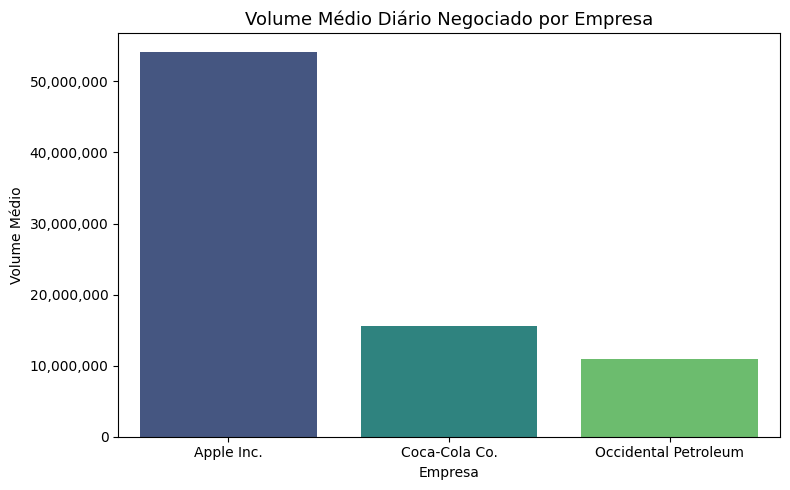

,empresa,Volume Médio,Desvio Padrão
0,Apple Inc.,54125242,19853171
1,Coca-Cola Co.,15626188,4989578
2,Occidental Petroleum,10912530,5497185


In [ ]:
# Agrupar por empresa e calcular média e desvio padrão
volume_stats = df_stocks.groupby("empresa")["volume"].agg(["mean", "std"]).reset_index()
volume_stats = volume_stats.rename(columns={"mean": "Volume Médio", "std": "Desvio Padrão"})

# Formatar os números para ficar mais legível
volume_stats["Volume Médio"] = volume_stats["Volume Médio"].apply(lambda x: int(round(x)))
volume_stats["Desvio Padrão"] = volume_stats["Desvio Padrão"].apply(lambda x: int(round(x)))

# Salvar tabela
volume_stats.to_csv("outputs/outputsAnalise/tabelas/volume_medio_por_empresa.csv", index=False)

# Plotar gráfico
plt.figure(figsize=(8,5))
sns.barplot(data=volume_stats, x="empresa", y="Volume Médio", palette="viridis")

# Deixar o eixo y legível com separador de milhar
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title("Volume Médio Diário Negociado por Empresa", fontsize=13)
plt.xlabel("Empresa")
plt.ylabel("Volume Médio")
plt.tight_layout()

# Salvar gráfico
plt.savefig("outputs/outputsAnalise/graficos/volume_medio_por_empresa.png", dpi=300)
plt.show()

volume_stats.head()


C:\Users\André\AppData\Local\Temp\ipykernel_5724\611955662.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_stocks["data"] = pd.to_datetime(df_stocks["data"])


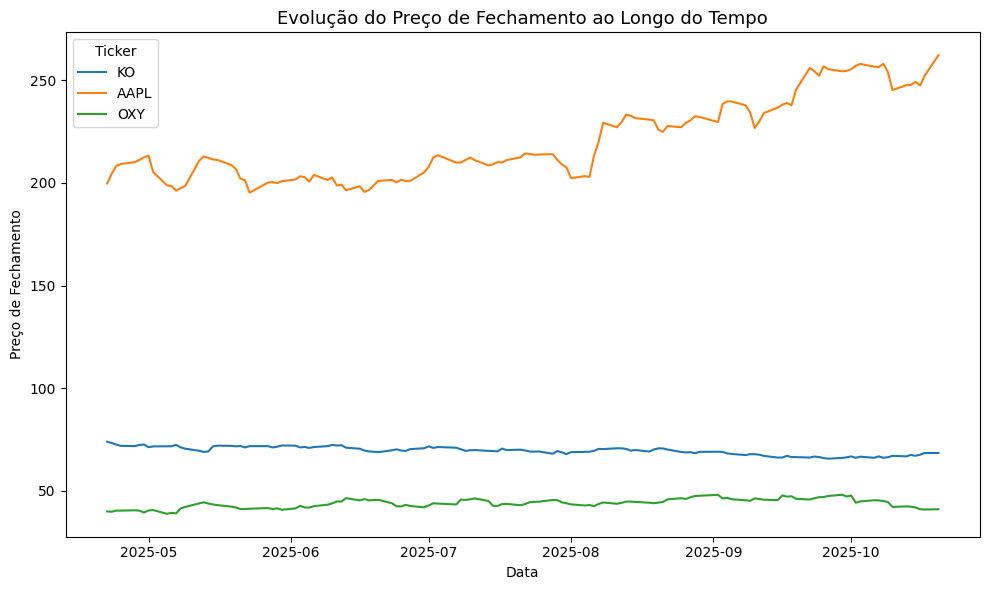

In [ ]:
# Garantir que a coluna 'data' esteja em formato datetime
df_stocks["data"] = pd.to_datetime(df_stocks["data"])

# Ordenar por data (boa prática)
df_stocks = df_stocks.sort_values("data")

# Plotar gráfico de linhas
plt.figure(figsize=(10,6))
sns.lineplot(data=df_stocks, x="data", y="fechamento", hue="ticker", linewidth=1.5)
plt.title("Evolução do Preço de Fechamento ao Longo do Tempo", fontsize=13)
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento em dólar")
plt.legend(title="Ticker")
plt.tight_layout()

# Salvar gráfico
plt.savefig("outputs/outputsAnalise/graficos/evolucao_preco_fechamento.png", dpi=300)
plt.show()


## 3.2 Análise das movimentações da Berkshire Hathaway

In [6]:
# Garantir que o caminho de saída exista
os.makedirs("outputs/outputsAnalise", exist_ok=True)

# Carregar parquet
df_berkshire = pd.read_parquet("data_clean/movimentacoesBerkshireHathaway_clean.parquet")

# Verificar colunas
print("Colunas disponíveis:", df_berkshire.columns)

Colunas disponíveis: Index(['Ação', 'Ações ou Valor Principal', 'Valor de Mercado',
       '% do Portfólio', '% Anterior do Portfólio', 'Posição',
       'Mudança em Ações', '% de Mudança', 'Primeiro Trimestre Possuído',
       'Data da Fonte', 'Data Reportada'],
      dtype='object')


C:\Users\André\AppData\Local\Temp\ipykernel_5724\2128183272.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_valor, x="Ação", y="Valor de Mercado", palette="magma")


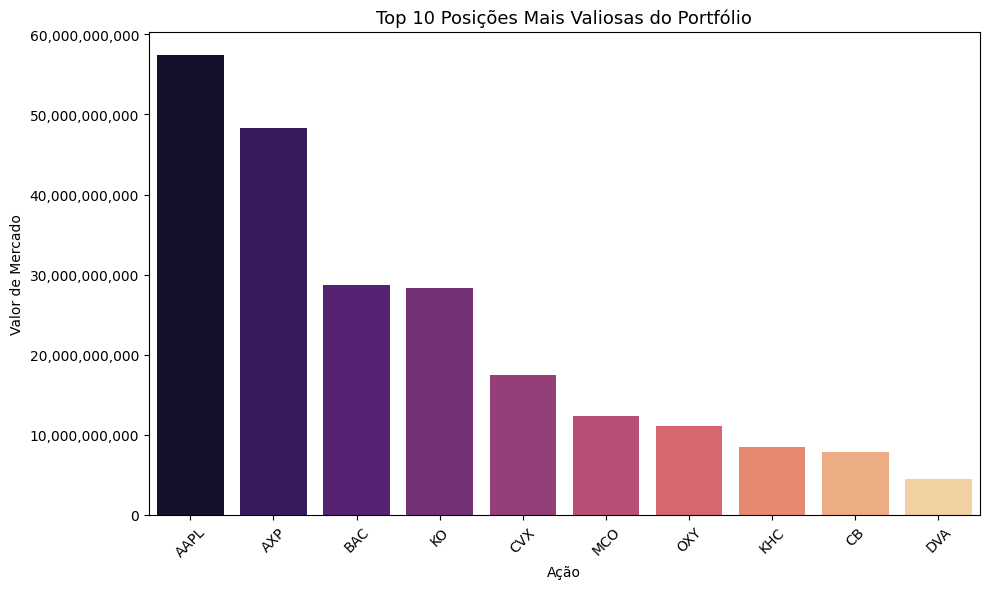

In [ ]:
# Ordenar por Valor de Mercado e pegar top 10
top10_valor = df_berkshire.sort_values("Valor de Mercado", ascending=False).head(10)

# Salvar tabela
top10_valor.to_csv("outputs/outputsAnalise/tabelas/top10_valor_mercado.csv", index=False)

# Plotar gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(data=top10_valor, x="Ação", y="Valor de Mercado", palette="magma")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title("Top 10 Posições Mais Valiosas do Portfólio", fontsize=13)
plt.xlabel("Ação")
plt.ylabel("Valor de Mercado")
plt.xticks(rotation=45)
plt.tight_layout()

# Salvar gráfico
plt.savefig("outputs/outputsAnalise/graficos/top10_valor_mercado.png", dpi=300)
plt.show()


Este gráfico abaixo mostra quais ações tiveram aumento ou redução da participação no portfólio da Berkshire Hathaway.

- Barras azuis (positivas): ações que aumentaram sua participação.

- Barras vermelhas (negativas): ações que diminuíram.

- Serve para identificar rapidamente quais ativos Buffett fortaleceu ou reduziu.

C:\Users\André\AppData\Local\Temp\ipykernel_5724\2050914368.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_berkshire.sort_values("Diferença % Portfólio", ascending=False),


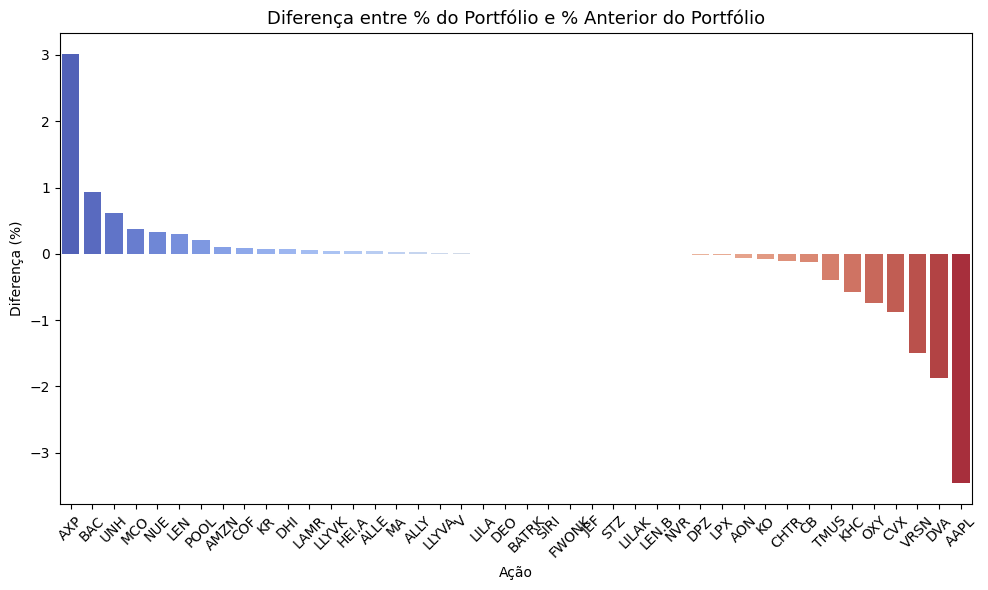

In [ ]:
# Criar coluna de diferença
df_berkshire["Diferença % Portfólio"] = df_berkshire["% do Portfólio"] - df_berkshire["% Anterior do Portfólio"]

# Salvar tabela
df_berkshire[["Ação", "% do Portfólio", "% Anterior do Portfólio", "Diferença % Portfólio"]].to_csv(
    "outputs/outputsAnalise/tabelas/comparacao_percentual_portfolio.csv", index=False
)

# Plotar gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(data=df_berkshire.sort_values("Diferença % Portfólio", ascending=False),
            x="Ação", y="Diferença % Portfólio", palette="coolwarm")
plt.title("Diferença entre % do Portfólio e % Anterior do Portfólio", fontsize=13)
plt.xlabel("Ação")
plt.ylabel("Diferença (%)")
plt.xticks(rotation=45)
plt.tight_layout()

# Salvar gráfico
plt.savefig("outputs/outputsAnalise/graficos/diferenca_percentual_portfolio.png", dpi=300)
plt.show()


O histograma abaixo mostra a frequência das mudanças percentuais nas posições do portfólio.

- A maioria das mudanças está próxima de 0%, indicando que a maioria das ações não sofreu alterações drásticas.

- Alguns picos para mudanças maiores ou menores indicam ajustes significativos em poucas ações.

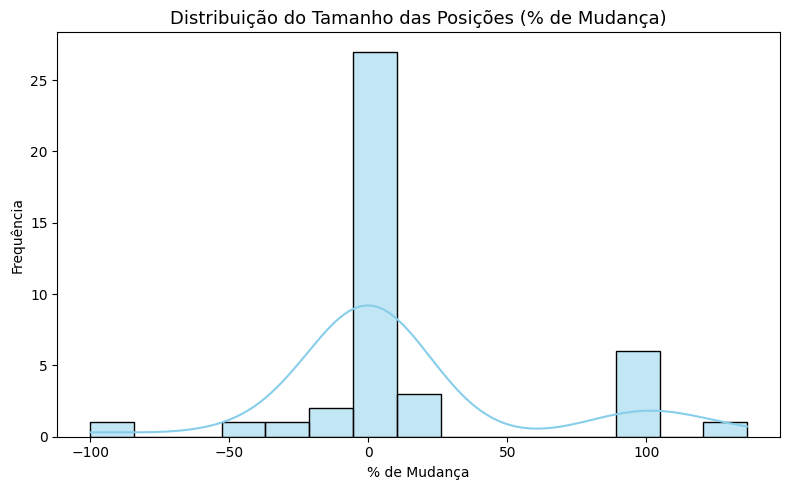

In [ ]:
# Salvar tabela de % de mudança
df_berkshire[["Ação", "% de Mudança"]].to_csv(
    "outputs/outputsAnalise/distribuicao_percentual_mudanca.csv", index=False
)

# Plotar histograma
plt.figure(figsize=(8,5))
sns.histplot(df_berkshire["% de Mudança"], bins=15, kde=True, color="skyblue")
plt.title("Distribuição do Tamanho das Posições (% de Mudança)", fontsize=13)
plt.xlabel("% de Mudança")
plt.ylabel("Frequência")
plt.tight_layout()

# Salvar gráfico
plt.savefig("outputs/outputsAnalise/graficos/distribuicao_percentual_mudanca.png", dpi=300)
plt.show()


Este gráfico abaixo mostra quais ações foram mais ativamente ajustadas ao longo dos relatórios da Berkshire Hathaway.

- Barras mais altas indicam ações que Buffett comprou ou vendeu com mais frequência.

- Permite identificar ativos que receberam atenção mais constante da gestão.

C:\Users\André\AppData\Local\Temp\ipykernel_5724\4125954545.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=freq_mudancas, x="Ação", y="Mudança em Ações", palette="plasma")


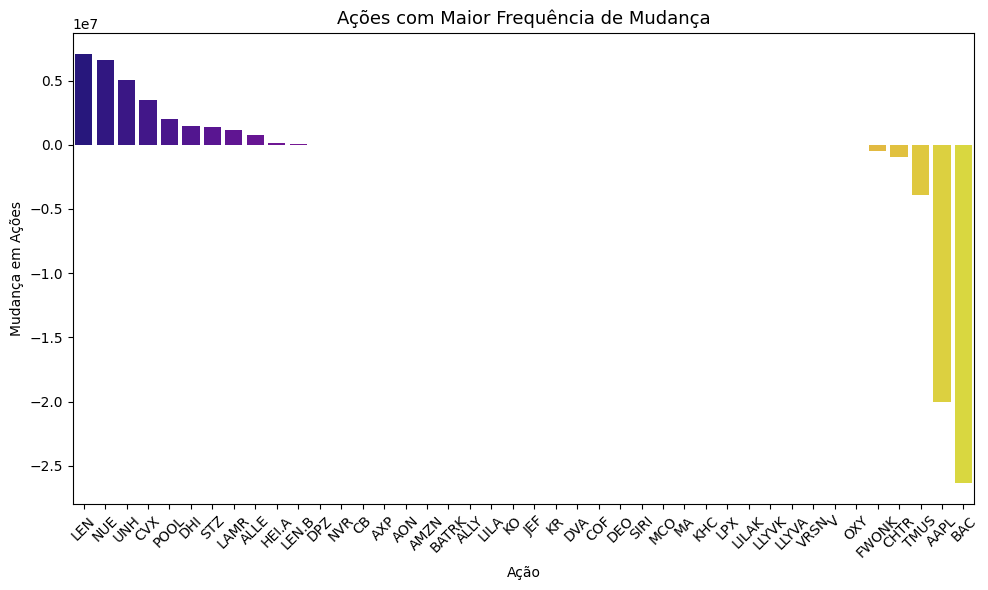

In [ ]:
# Agrupar por ação e somar mudanças
freq_mudancas = df_berkshire.groupby("Ação")["Mudança em Ações"].sum().reset_index()
freq_mudancas = freq_mudancas.sort_values("Mudança em Ações", ascending=False)

# Salvar tabela
freq_mudancas.to_csv("outputs/outputsAnalise/tabelas/acoes_maior_frequencia_mudanca.csv", index=False)

# Plotar gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(data=freq_mudancas, x="Ação", y="Mudança em Ações", palette="plasma")
plt.title("Ações com Maior Frequência de Mudança", fontsize=13)
plt.xlabel("Ação")
plt.ylabel("Mudança em Ações")
plt.xticks(rotation=45)
plt.tight_layout()

# Salvar gráfico
plt.savefig("outputs/outputsAnalise/graficos/acoes_maior_frequencia_mudanca.png", dpi=300)
plt.show()


## 3.3 Analise das notícias sobre Warren Buffett e empresas escolhidas

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
import re
from collections import Counter
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese')) | set(stopwords.words('english'))

# Caminhos
input_path = "data_clean/news_buffett_clean.parquet"
output_path = "outputs/outputsAnalise/"
os.makedirs(output_path, exist_ok=True)

# Carregar parquet
df_news = pd.read_parquet(input_path)

# Converter coluna de data
df_news['data'] = pd.to_datetime(df_news['data'], errors='coerce')
df_news = df_news.dropna(subset=['data'])

# Filtrar apenas notícias de 2019 em diante
df_news = df_news[df_news['data'] >= '2025-09-01']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\André\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\André\AppData\Local\Temp\ipykernel_5724\3690343443.py:22: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_news['data'] = pd.to_datetime(df_news['data'], errors='coerce')


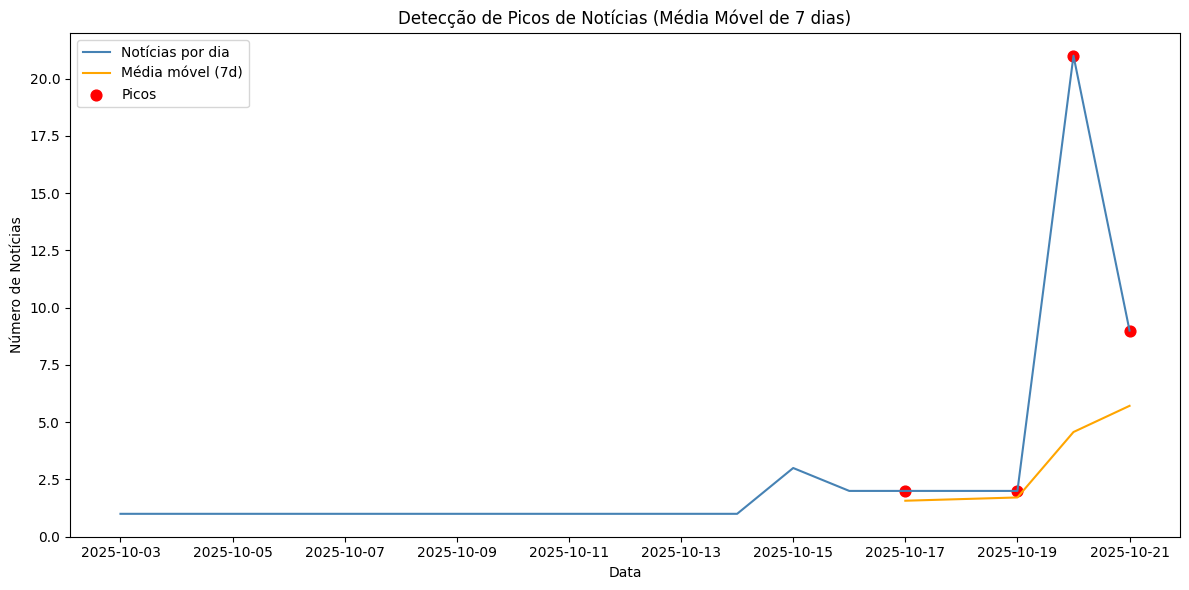

In [ ]:
# Agrupar por data
daily_counts = df_news.groupby(df_news['data'].dt.date).size().reset_index(name='num_noticias')
daily_counts['data'] = pd.to_datetime(daily_counts['data'])
daily_counts['media_movel_7d'] = daily_counts['num_noticias'].rolling(window=7).mean()
daily_counts['pico'] = daily_counts['num_noticias'] > daily_counts['media_movel_7d']

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_counts, x='data', y='num_noticias', label='Notícias por dia', color='steelblue')
sns.lineplot(data=daily_counts, x='data', y='media_movel_7d', label='Média móvel (7d)', color='orange')
plt.scatter(daily_counts.loc[daily_counts['pico'], 'data'],
            daily_counts.loc[daily_counts['pico'], 'num_noticias'],
            color='red', label='Picos', s=60)
plt.title('Detecção de Picos de Notícias (Média Móvel de 7 dias)')
plt.xlabel('Data')
plt.ylabel('Número de Notícias')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join("outputs/outputsAnalise/graficos", "news_picos_noticias.png"), dpi=300)
plt.show()

# Salvar CSV
daily_counts.to_csv(os.path.join("outputs/outputsAnalise/tabelas", "news_picos_noticias.csv"), index=False)

C:\Users\André\AppData\Local\Temp\ipykernel_5724\2609584653.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_palavras, x='frequencia', y='palavra', palette='Blues_r')


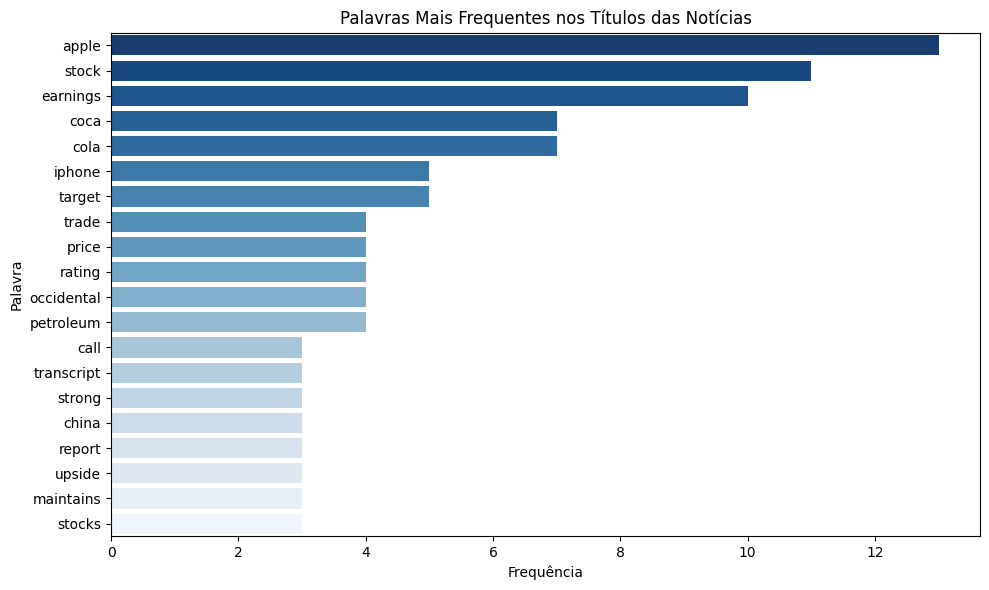

✅ Análises concluídas e salvas em: outputs/outputsAnalise/


In [ ]:
# Juntar todos os títulos e tokenizar
titulos = " ".join(df_news['titulo'].dropna().astype(str)).lower()

# Remover pontuação e dividir em palavras
tokens = re.findall(r'\b[a-záàâãéèêíïóôõöúçñ]{3,}\b', titulos)

# Remover stopwords
tokens_filtrados = [t for t in tokens if t not in stop_words]

# Contar palavras
contagem = Counter(tokens_filtrados)
top_palavras = pd.DataFrame(contagem.most_common(20), columns=['palavra', 'frequencia'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_palavras, x='frequencia', y='palavra', palette='Blues_r')
plt.title('Palavras Mais Frequentes nos Títulos das Notícias')
plt.xlabel('Frequência')
plt.ylabel('Palavra')
plt.tight_layout()
plt.savefig(os.path.join("outputs/outputsAnalise/graficos", "news_palavras_frequentes.png"), dpi=300)
plt.show()

# Salvar CSV
top_palavras.to_csv(os.path.join("outputs/outputsAnalise/tabelas", "news_palavras_frequentes.csv"), index=False)



C:\Users\André\AppData\Local\Temp\ipykernel_5724\2062592849.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=termo_counts, x='quantidade', y='termo', palette='viridis')


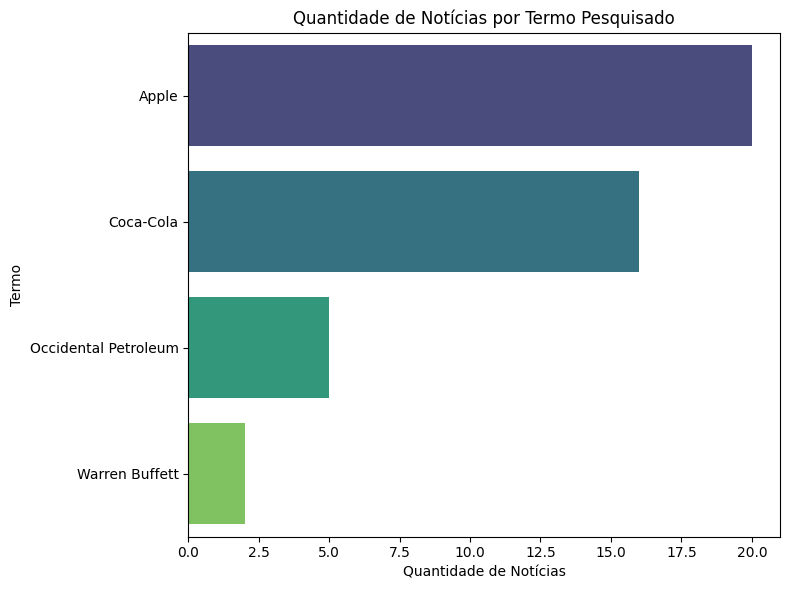

✅ Todas as análises concluídas e salvas em: outputs/outputsAnalise/


In [ ]:
# Contar número de notícias por termo
termo_counts = df_news['termo'].value_counts().reset_index()
termo_counts.columns = ['termo', 'quantidade']

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=termo_counts, x='quantidade', y='termo', palette='viridis')
plt.title('Quantidade de Notícias por Termo Pesquisado')
plt.xlabel('Quantidade de Notícias')
plt.ylabel('Termo')
plt.tight_layout()
plt.savefig(os.path.join("outputs/outputsAnalise/graficos", "news_quantidade_por_termo.png"), dpi=300)
plt.show()

# Salvar CSV
termo_counts.to_csv(os.path.join("outputs/outputsAnalise/tabelas", "news_quantidade_por_termo.csv"), index=False)

logging.info("✅ Todas as análises concluídas e salvas em:", output_path)

# 4️⃣ Considerações Finais

O pipeline desenvolvido demonstra a aplicação prática de técnicas de Web Mining e Web Scraping integradas a ETL analítico, proporcionando uma base consolidada para análise de correlação entre eventos do mercado financeiro e decisões de investimento da Berkshire Hathaway.

A coleta automatizada e o tratamento dos dados permitiram a geração de um banco analítico reproduzível, que pode ser facilmente explorado em ferramentas SQL ou visualizado em dashboards, possibilitando estudos mais profundos sobre o comportamento do mercado diante das decisões de grandes investidores.

---

# ✅ Arquivos Entregues

- Notebook: pipeline_warren_buffett.ipynb

- Dados tratados:

    - stock_prices.parquet

    - portfolio_movements.parquet

    - news.parquet

- Arquivo de dependências: requirements.txt